In [8]:
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import pandas as pd
import json
import geopandas as gpd
import seaborn as sns
from shapely.geometry import Point

## NSS Data Science Project 2 - Silver Sharks Geospatial API

### 4. Create a choropleth showing the number of burglaries per 1000 residents for each census tract.

In [2]:
tract_pop_income = pd.read_csv("../data/tract_pop_income.csv")
tract_pop_income.head(5)

,Unnamed: 0,tract,population,median_income,burglary_count,burg_per_1000,log_population
0,0,10104,2955,64844,8,2.707276,7.991254
1,1,10105,4435,64688,3,0.676437,8.397283
2,2,10106,3397,63864,9,2.649397,8.130648
3,3,10201,4157,62829,4,0.962232,8.332549
4,4,10202,3962,78750,1,0.252398,8.284504


In [3]:
tract_pop_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      146 non-null    int64  
 1   tract           146 non-null    int64  
 2   population      146 non-null    int64  
 3   median_income   146 non-null    int64  
 4   burglary_count  146 non-null    int64  
 5   burg_per_1000   146 non-null    float64
 6   log_population  146 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 8.1 KB


In [4]:
census_tract = gpd.read_file('../data/tl_2019_47_tract/tl_2019_47_tract.shp')
type(census_tract)

geopandas.geodataframe.GeoDataFrame

In [5]:
print(census_tract.crs)
census_tract.head()

epsg:4269


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,47,165,021002,47165021002,210.02,Census Tract 210.02,G5020,S,30654374,207994,+36.3521602,-086.6464309,"POLYGON ((-86.69927 36.32775, -86.69923 36.327..."
1,47,165,020901,47165020901,209.01,Census Tract 209.01,G5020,S,23811766,3412697,+36.3483143,-086.4070907,"POLYGON ((-86.43949 36.35962, -86.43915 36.359..."
2,47,165,020300,47165020300,203,Census Tract 203,G5020,S,14629292,0,+36.5796910,-086.5114955,"POLYGON ((-86.53716 36.56852, -86.53713 36.568..."
3,47,165,020902,47165020902,209.02,Census Tract 209.02,G5020,S,9756715,0,+36.3724350,-086.4411274,"POLYGON ((-86.47106 36.38238, -86.47081 36.382..."
4,47,165,020800,47165020800,208,Census Tract 208,G5020,S,10235406,37743,+36.4005117,-086.4528100,"POLYGON ((-86.48786 36.37320, -86.48783 36.373..."


In [6]:
burglary_reports = pd.read_csv("../data/burglary_reports.csv", 
                                engine='python')

In [9]:
burglary_reports['geometry'] = burglary_reports\
                                               .apply(lambda x: Point((x.longitude,
                                                                       x.latitude)),
                                                      axis=1)

burglary_reports.head()

,Unnamed: 0,incident_number,offense_description,latitude,longitude,zip_code,date_reported,geometry
0,0,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77 36.15)
1,1,20210248840,BURGLARY- AGGRAVATED,36.20,-86.63,NaN,2021-05-04,POINT (-86.63 36.2)
2,2,20210244919,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78 36.14)
3,3,20210244892,BURGLARY- AGGRAVATED,36.14,-86.78,NaN,2021-05-02,POINT (-86.78 36.14)
4,4,20210249540,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77 36.15)


In [10]:
burglary_geo = gpd.GeoDataFrame(burglary_reports,  
                                crs=census_tract.crs,
                                geometry = burglary_reports['geometry'])

In [11]:
census_tract = census_tract[['COUNTYFP', 'TRACTCE', 'NAME', 'geometry']]
census_tract['COUNTYFP'] = census_tract['COUNTYFP'].apply(pd.to_numeric)
census_tract = census_tract[census_tract['COUNTYFP'] == 37]
census_tract.head()

,COUNTYFP,TRACTCE,NAME,geometry
27,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
36,37,010103,101.03,"POLYGON ((-86.91752 36.33976, -86.91747 36.339..."
37,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
38,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
63,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."


In [13]:
burglary_by_tract = gpd.sjoin(burglary_geo, 
                              census_tract, 
                              op = 'within')

In [14]:
#drops redundant index
burglary_by_tract = burglary_by_tract.drop(columns='index_right')

#renames tract column
burglary_by_tract = burglary_by_tract.rename(columns={'TRACTCE':'tract'})
burglary_by_tract = burglary_by_tract.drop(columns='incident_number')
print(burglary_by_tract.shape)
display(burglary_by_tract.head())

(1049, 10)


,Unnamed: 0,offense_description,latitude,longitude,zip_code,date_reported,geometry,COUNTYFP,tract,NAME
0,0,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),37,016000,160
4,4,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-05-05,POINT (-86.77000 36.15000),37,016000,160
63,63,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-04-02,POINT (-86.76000 36.14000),37,016000,160
129,129,BURGLARY- AGGRAVATED,36.14,-86.76,NaN,2021-01-05,POINT (-86.76000 36.14000),37,016000,160
158,158,BURGLARY- AGGRAVATED,36.15,-86.77,NaN,2021-04-21,POINT (-86.77000 36.15000),37,016000,160


In [15]:
census_tract_names = burglary_by_tract['NAME']
census_tract_names = pd.DataFrame(census_tract_names)
polygon_nash = pd.merge(census_tract, census_tract_names, on = 'NAME')
polygon_nash.drop_duplicates(subset='NAME')

,COUNTYFP,TRACTCE,NAME,geometry
0,37,010106,101.06,"POLYGON ((-86.83089 36.26570, -86.83016 36.265..."
9,37,010202,102.02,"POLYGON ((-86.82482 36.33225, -86.82480 36.332..."
10,37,010104,101.04,"POLYGON ((-86.97440 36.24991, -86.97244 36.252..."
18,37,013300,133,"POLYGON ((-86.86843 36.16436, -86.86836 36.164..."
31,37,018102,181.02,"POLYGON ((-86.88737 36.11771, -86.88733 36.117..."
...,...,...,...,...
996,37,018904,189.04,"POLYGON ((-86.73805 36.06626, -86.73780 36.066..."
1006,37,018905,189.05,"POLYGON ((-86.74457 36.05547, -86.74447 36.055..."
1030,37,013601,136.01,"POLYGON ((-86.84383 36.16325, -86.84375 36.163..."
1035,37,018301,183.01,"POLYGON ((-87.03820 36.09382, -87.03819 36.093..."


AttributeError: 'Line2D' object has no property 'column'

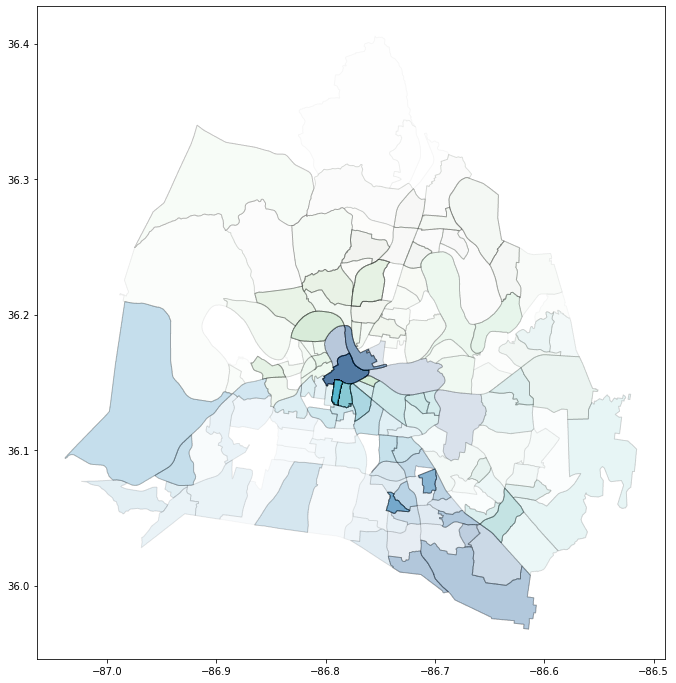

In [18]:
ax = polygon_nash.plot(column='TRACTCE', 
                       figsize = (12, 12), 
                       edgecolor='black',
                       alpha=0.03,
                       cmap='GnBu')

tract_pop_income.plot(column = 'burg_per_1000',
                      cmap='OrRd',
                      legend=True,
                      ax=ax)

plt.title('Burglaries per 1000 People by Census Tract',
          fontsize=15)

plt.show();